In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.isotonic import IsotonicRegression

In [2]:
strokes_gained_putts = {'Uphill':[],'Downhill':[]}
for year in range(2003,2010):
    data = pd.read_csv('data/%d.csv'%(year,))
    uCRHtps = list(itertools.product(pd.unique(data['Course_#']),pd.unique(data.Round),pd.unique(data.Hole)))
    data = data[['Course_#','Round','Hole','Player_#','Hole_Score','Shot','From_Location(Scorer)','To_Location(Laser)','Shots_taken_from_location',
            'Distance_from_hole','Started_at_X','Started_at_Y','Went_to_X','Went_to_Y','Started_at_Z','Went_to_Z']].values

    for crhtup in uCRHtps:
        subset = data[np.where((data[:,0]==crhtup[0]) & (data[:,1]==crhtup[1]) & (data[:,2]==crhtup[2]))]
        if subset.shape[0]<50:
            continue
        players = pd.unique(subset[:,3])
        scores = {player:int(subset[np.where(subset[:,3]==player)][0,4]) for player in players}
        ave_score = np.mean(np.array([scores.get(player) for player in players]))

        for player in players:
            sub = subset[np.where(subset[:,3]!=player)]
            model = IsotonicRegression(out_of_bounds='clip')
            model.fit(sub[np.where(sub[:,6]=='Green')][:,9],sub[np.where(sub[:,6]=='Green')][:,8])

            #tot_strokes_gained = ave_score - scores[player]

            #model_predicted_strokes_gained = 0

            sub = subset[np.where(subset[:,3]==player)]

            for shot in range(min(sub[:,5]),sub[0,4]+1):
                if shot==sub[0,4]:
                    if sub[np.where(sub[:,5]==shot)][0,6] != 'Green':
                        continue
                    if sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14] > 0:
                        strokes_gained_putts['Uphill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                               model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 1))
                    else:
                        strokes_gained_putts['Downhill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                                 model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 1))
                else:
                    if sub[np.where(sub[:,5]==shot)][0,6] != 'Green':
                        continue
                    if sub[np.where(sub[:,5]==shot)][0,14] - sub[np.where(sub[:,5]==shot)][0,13] > 0:
                        strokes_gained_putts['Uphill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                               model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] -
                                                               model.predict([sub[np.where(sub[:,5]==shot+1)][0,9]])[0] - 1))
                    else:
                        strokes_gained_putts['Downhill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                                 model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 
                                                                 model.predict([sub[np.where(sub[:,5]==shot+1)][0,9]])[0] - 1))


/Users/adamlevin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [103]:
data = pd.read_csv('data/2008.csv')

In [104]:
uCRHtps = list(itertools.product(pd.unique(data['Course_#']),pd.unique(data.Round),pd.unique(data.Hole)))

data = data[['Course_#','Round','Hole','Player_#','Hole_Score','Shot','From_Location(Scorer)','To_Location(Laser)','Shots_taken_from_location',
            'Distance_from_hole','Started_at_X','Started_at_Y','Went_to_X','Went_to_Y','Started_at_Z','Went_to_Z']].values

In [105]:
# def convert_cats(cat):
#     if cat in ['Green Side Bunker','Fairway Bunker']:
#         return 'Bunker'
#     elif cat not in ['Green','Fairway','Fringe','Primary Rough','Intermediate Rough','Tee Box']:
#         return 'Other'
#     else:
#         return cat

# if 'Cat' in data.columns:
#     data = data.drop('Cat',axis=1)
# data.insert(len(data.columns),'Cat',[convert_cats(c) for c in data['From_Location(Scorer)'].tolist()])

In [66]:
#errors = []
#strokes_gained_per_cat = {'Bunker':[],'Other':[],'Green':[],'Fairway':[],'Fringe':[],'Primary Rough':[],
#                             'Intermediate Rough':[], 'Tee Box':[]}
strokes_gained_putts = {'Uphill':[],'Downhill':[]}

for crhtup in uCRHtps:
    subset = data[np.where((data[:,0]==crhtup[0]) & (data[:,1]==crhtup[1]) & (data[:,2]==crhtup[2]))]
    if subset.shape[0]<50:
        continue
    players = pd.unique(subset[:,3])
    scores = {player:int(subset[np.where(subset[:,3]==player)][0,4]) for player in players}
    ave_score = np.mean(np.array([scores.get(player) for player in players]))

    for player in players:
        sub = subset[np.where(subset[:,3]!=player)]
        model = IsotonicRegression(out_of_bounds='clip')
        model.fit(sub[np.where(sub[:,6]=='Green')][:,9],sub[np.where(sub[:,6]=='Green')][:,8])

        #tot_strokes_gained = ave_score - scores[player]

        #model_predicted_strokes_gained = 0

        sub = subset[np.where(subset[:,3]==player)]

        for shot in range(min(sub[:,5]),sub[0,4]+1):
            if shot==sub[0,4]:
                if sub[np.where(sub[:,5]==shot)][0,6] != 'Green':
                    continue
                if sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14] > 0:
                    strokes_gained_putts['Uphill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                           sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14],
                                                           model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 1))
                else:
                    strokes_gained_putts['Downhill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                             sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14],
                                                             model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 1))
            else:
                if sub[np.where(sub[:,5]==shot)][0,6] != 'Green':
                    continue
                if sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14] > 0:
                    strokes_gained_putts['Uphill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                           sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14],
                                                           model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] -
                                                           model.predict([sub[np.where(sub[:,5]==shot+1)][0,9]])[0] - 1))
                else:
                    strokes_gained_putts['Downhill'].append((sub[np.where(sub[:,5]==shot)][0,9],
                                                             sub[np.where(sub[:,5]==shot)][0,15] - sub[np.where(sub[:,5]==shot)][0,14],
                                                             model.predict([sub[np.where(sub[:,5]==shot)][0,9]])[0] - 
                                                             model.predict([sub[np.where(sub[:,5]==shot+1)][0,9]])[0] - 1))
                        
    #errors.append((model_predicted_strokes_gained - tot_strokes_gained))


#print pd.Series(errors).describe()
# for cat in strokes_gained_per_cat:
#     print cat, pd.Series(strokes_gained_per_cat[cat]).describe()
for slope in strokes_gained_putts:
    print slope, pd.Series(strokes_gained_putts[slope]).describe()

Uphill count                                                216444
unique                                               216434
top       (2.39198802781, 0.00699999999995, -1.110223024...
freq                                                      3
dtype: object
Downhill count                                      185389
unique                                     185380
top       (14.1458661558, -0.116, 0.777777777778)
freq                                            2
dtype: object


In [105]:
strokes_gained_putts['Uphill'].sort()
strokes_gained_putts['Downhill'].sort()
x1 = np.array([i[1] for i in strokes_gained_putts['Uphill'] if i[0]<14 and i[0]>4])
y1 = np.array([i[2] for i in strokes_gained_putts['Uphill'] if i[0]<14 and i[0]>4])
x2 = np.array([i[1] for i in strokes_gained_putts['Downhill'] if i[0]<14 and i[0]>4])
y2 = np.array([i[2] for i in strokes_gained_putts['Downhill'] if i[0]<14 and i[0]>4])

bins = np.linspace(np.percentile(x1,1), np.percentile(x1,99), 15)
b1 = np.digitize(x1, bins)
x1ms = [x1[b1 == i].mean() for i in range(1, len(bins))]
y1ms = [y1[b1 == i].mean() for i in range(1, len(bins))]
bins = np.linspace(np.percentile(x2,1), np.percentile(x2,99), 15)
b2 = np.digitize(x2, bins)
x2ms = [x2[b2 == i].mean() for i in range(1, len(bins))]
y2ms = [y2[b2 == i].mean() for i in range(1, len(bins))]

In [106]:
pd.Series(x1).describe()

count    59473.000000
mean         0.116831
std          0.092089
min          0.001000
25%          0.048000
50%          0.096000
75%          0.163000
max          1.899000
dtype: float64

In [107]:
print [len(x2[b2==i]) for i in range(1,len(bins))]

[304, 449, 591, 902, 1181, 1596, 2236, 3058, 3744, 5071, 6624, 7992, 9604, 9712]


In [9]:
def confidence_interval_difference_of_two_means(sample_1,sample_2,its,p):
    mean_diffs = []
    for _ in xrange(its):
        mean_1 = np.mean(np.random.choice(sample_1,len(sample_1)))
        mean_2 = np.mean(np.random.choice(sample_2,len(sample_2)))
        mean_diffs.append(mean_1 - mean_2)
    return np.percentile(mean_diffs,[(100.0-p)/2,(p+100.0)/2])

In [10]:
def hypo_test_difference_of_two_means_one_sided(sample_b,sample_s,its):
    test_stat = np.mean(sample_b) - np.mean(sample_s)
    haps = 0
    for _ in xrange(its):
        pooled_sample = np.append(sample_b,sample_s)
        np.random.shuffle(pooled_sample)
        if np.mean(pooled_sample[:len(sample_b)]) - np.mean(pooled_sample[len(sample_b):]) >= test_stat:
            haps += 1
    return haps/float(its)

In [112]:
def confidence_interval_mean(sample,its,p):
    means = []
    for _ in xrange(its):
        mean = np.mean(np.random.choice(sample,len(sample)))
        means.append(mean)
    return np.percentile(means,[(100.0-p)/2,(p+100.0)/2])

In [11]:
def cohens_d(sample_1,sample_2):
    n1 = len(sample_1)
    n2 = len(sample_2)
    v1 = np.var(sample_1,ddof=1)
    v2 = np.var(sample_2,ddof=1)
    pooled_var = (((n1-1)*v1 + (n2-2)*v2) / (n1 + n2 -2)) ** .5
    return (np.mean(sample_1) - np.mean(sample_2)) / pooled_var

In [12]:
for i in range(len(bins)):
    print x1ms[i]
    print y1ms[i], y2ms[i], y1ms[i] - y2ms[i]
    print cohens_d(y1[b1 == i+1],y2[b2 == i+1])
    if y1ms[i]>y2ms[i]:
        p = hypo_test_difference_of_two_means_one_sided(y1[b1 == i+1],y2[b2 == i+1],5000)
        if p < .01:
            print p,'***'
        elif p < .05:
            print p,'**'
        elif p < .1:
            print p,'*'
    else:
        p = hypo_test_difference_of_two_means_one_sided(y2[b2 == i+1],y1[b1 == i+1],5000)
        if p < .01:
            print p,'***'
        elif p < .05:
            print p,'**'
        elif p < .1:
            print p,'*'
    print confidence_interval_difference_of_two_means(y1[b1 == i+1],y2[b2 == i+1],5000,99)

1.31647855324
-0.00112564142566 -0.00154154610592 0.000415904680257
0.00891210211676
0.0 ***
[ 0.00013677  0.00068498]
3.05460752859
-0.00406485086566 -0.0275324594206 0.0234676085549
0.105444314392
0.0 ***
[ 0.02186903  0.02496396]
5.24696929191
0.0101850304803 -0.0586122525444 0.0687972830247
0.151553123119
0.0 ***
[ 0.06433824  0.07320223]
7.4480288498
0.00988199145538 -0.034148425628 0.0440304170834
0.0846088231218
0.0 ***
[ 0.03791903  0.05013827]
9.6137234011
0.00398179362613 -0.0140255666375 0.0180073602636
0.0347687414537
0.0 ***
[ 0.01113967  0.0248569 ]
11.752214021
-0.00352372980507 -0.00197556016426 -0.0015481696408
-0.00314083125364
[-0.00843533  0.00542123]
13.8987651038
-0.00510520373491 0.0109428372357 -0.0160480409706
-0.0344871996044
0.0 ***
[-0.0231755  -0.00855235]
16.0458731923
-0.00261380073818 0.0141055360745 -0.0167193368127
-0.0383191465225
0.0 ***
[-0.02392142 -0.00972443]
18.1896402497
0.000111779809826 0.0137197509362 -0.0136079711264
-0.0330777203398
0.0 **

IndexError: list index out of range

In [6]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

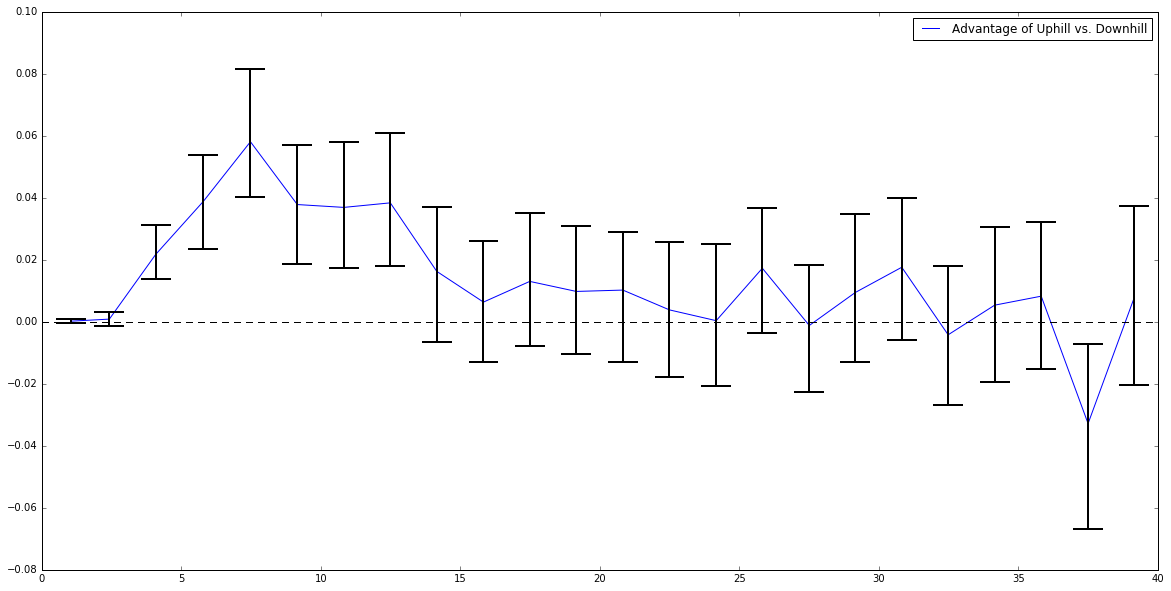

In [95]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.plot((np.array(x1ms)+np.array(x2ms))/2,np.array(y1ms)-np.array(y2ms),label='Advantage of Uphill vs. Downhill')
x = [0,0]
for i in range(len(bins)-1):
    ci = confidence_interval_difference_of_two_means(y1[b1 == i+1],y2[b2 == i+1],500,99)
    plt.plot([(x1ms[i] + x2ms[i])/2, (x1ms[i] + x2ms[i])/2], [ci[0], ci[1]], 'k-', lw=2)
    plt.plot([(x1ms[i] + x2ms[i])/2 - .5,(x1ms[i] + x2ms[i])/2 + .5],[ci[0],ci[0]],'k-', lw=2)
    plt.plot([(x1ms[i] + x2ms[i])/2 - .5,(x1ms[i] + x2ms[i])/2 + .5],[ci[1],ci[1]],'k-', lw=2)
    plt.plot([0,100],[0,0],'k--',lw=1)


plt.legend()
fig.savefig('Uphill vs Downhill.png')

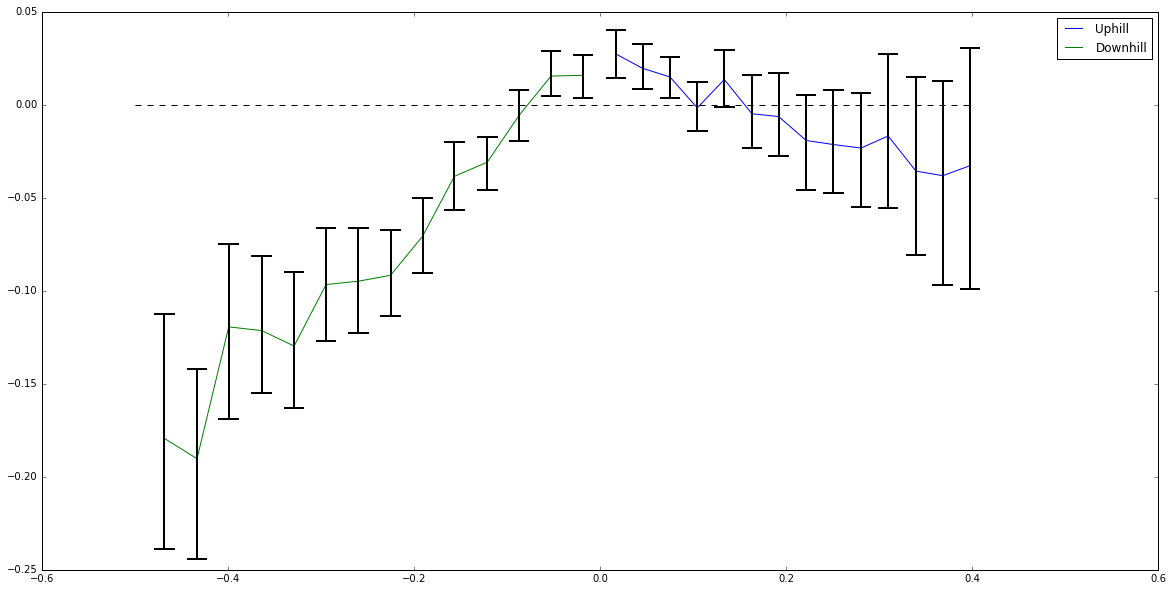

In [114]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.plot(x1ms,y1ms,label='Uphill')
plt.plot(x2ms,y2ms,label='Downhill')
plt.plot([-.5,.4],[0,0],'k--',lw=1)
for i in range(len(bins)-1):
    ci1 = confidence_interval_mean(y1[b1 == i+1],500,99)
    ci2 = confidence_interval_mean(y2[b2 == i+1],500,99)
    plt.plot([x1ms[i],x1ms[i]], [ci1[0], ci1[1]], 'k-', lw=2)
    plt.plot([x2ms[i],x2ms[i]], [ci2[0], ci2[1]], 'k-', lw=2)
    plt.plot([x1ms[i] - .01,x1ms[i] + .01],[ci1[0],ci1[0]],'k-', lw=2)
    plt.plot([x1ms[i] - .01,x1ms[i] + .01],[ci1[1],ci1[1]],'k-', lw=2)
    plt.plot([x2ms[i] - .01,x2ms[i] + .01],[ci2[0],ci2[0]],'k-', lw=2)
    plt.plot([x2ms[i] - .01,x2ms[i] + .01],[ci2[1],ci2[1]],'k-', lw=2)
plt.legend()

In [25]:
from scipy.stats import probplot
import scipy.stats

((array([-1.43017034, -1.36241765, -1.32553687, ...,  1.35592799,
          1.39280877,  1.46056145]),
  array([-1.625     , -1.61007463, -1.375     , ...,  1.70833333,
          1.75      ,  1.97740113])),
 (0.94315565560002335, 0.00086378158004732711, 0.94310378716969379))

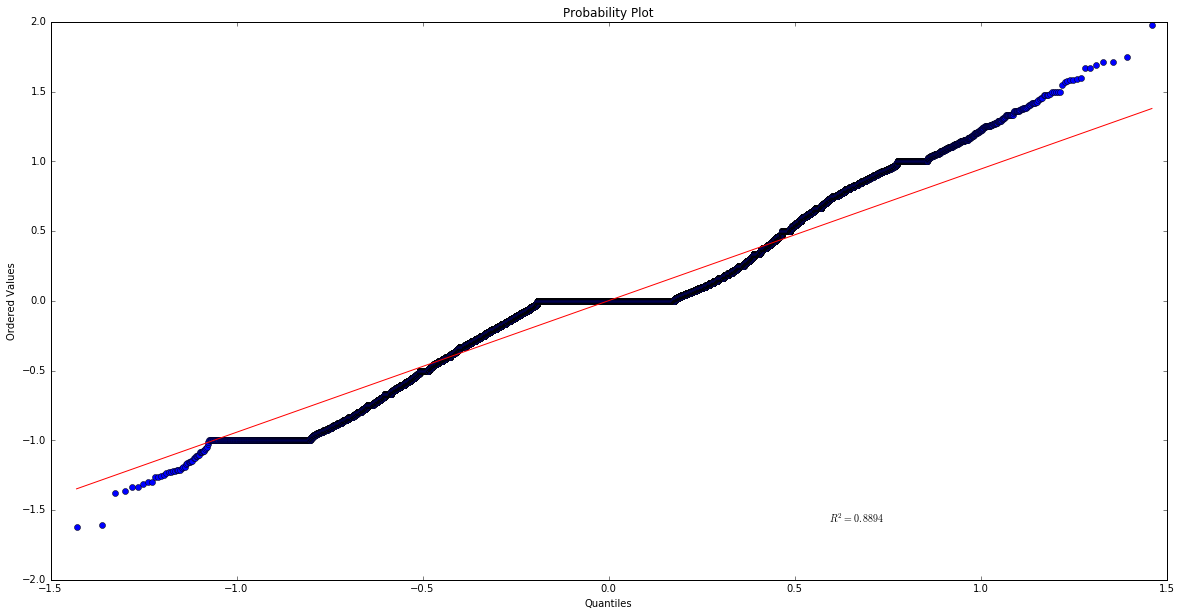

In [20]:
fig,ax = plt.subplots(figsize=(20, 10))
probplot(strokes_gained_per_cat['Green'],(np.mean(strokes_gained_per_cat['Green']), np.std(strokes_gained_per_cat['Green'])),plot=plt)

In [26]:
rv = scipy.stats.laplace(loc=np.mean(strokes_gained_per_cat['Green']), scale=(np.var(strokes_gained_per_cat['Green'])/2)**.5)

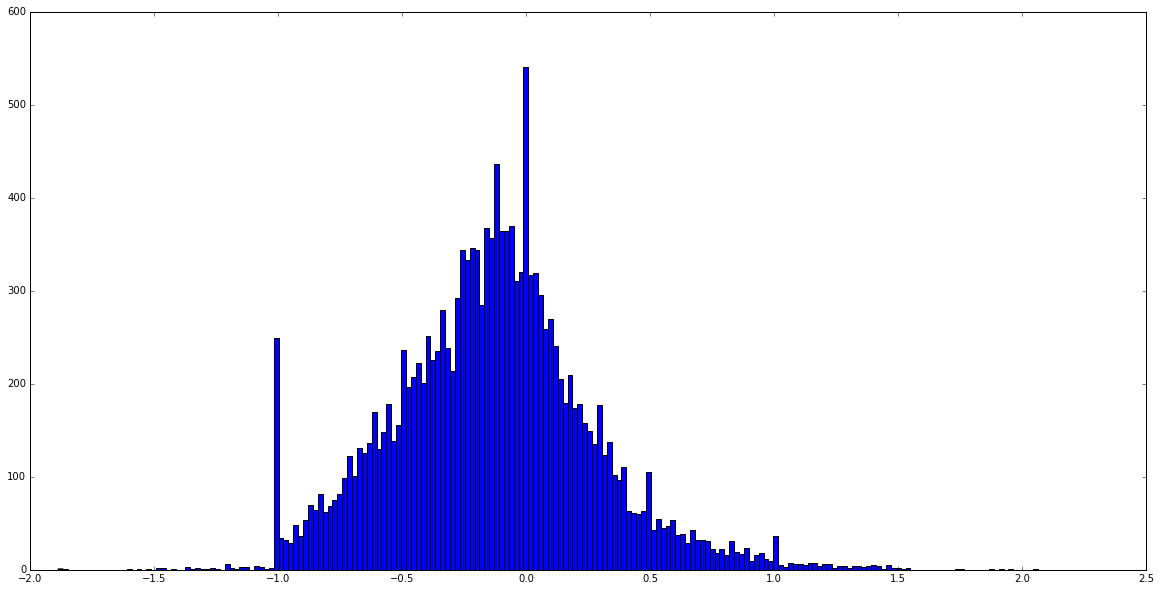

In [39]:
fig,ax = plt.subplots(figsize=(20, 10))
plt.hist(strokes_gained_per_cat['Primary Rough'],bins=200)
x = np.linspace(min(strokes_gained_per_cat['Primary Rough']),max(strokes_gained_per_cat['Primary Rough']),len(strokes_gained_per_cat['Primary Rough']))
#plt.plot(x,10000*rv.pdf(x))

In [42]:
def hypo_test_above_below_zero(sample,its):
    above_0,below_0 = 0,0
    for _ in xrange(its):
        samp = np.random.choice(sample,len(sample))
        if np.mean(samp)>0:
            above_0 +=1
        else:
            below_0 +=1
    return above_0/float(its) - below_0/float(its)

In [49]:
hypo_test_above_below_zero(strokes_gained_per_cat['Bunker'],10000)

-1.0

In [68]:
hypo_test_difference_of_two_means_one_sided(strokes_gained_putts['Uphill'],strokes_gained_putts['Downhill'],10000)

0.0

In [115]:
import pyximport; pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x11fead0d0>)